# Combine, clean, and export the data
### Written by Minh Phan

Now that we have all the demo data we need, it's time to synthesize the variables together

## Loading data
Begin by loading all the data into disk

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# era5 = xr.combine_by_coords([xr.open_mfdataset('demonstrated data/era5/eastward_wind_at_10_metres/*.nc'),
#                              xr.open_mfdataset('demonstrated data/era5/northward_wind_at_10_metres/*.nc')])

era5 = xr.open_mfdataset('demonstrated data/era5/*/*.nc')
salinity = xr.open_dataset('demonstrated data/salinity_at_0_49m.nc')
sst = xr.open_mfdataset('demonstrated data/earth_data/*/*.nc')['analysed_sst'] # we only have one collection in earth_data directory currently

## Process ERA5 data and calculate speed/direction

In [3]:
# adding calculated variables (direction and speed)
era5 = era5.assign(speed = np.sqrt(era5.eastward_wind_at_10_metres**2 + era5.northward_wind_at_10_metres**2))
era5 = era5.assign(direction = np.rad2deg(np.arctan2(era5.northward_wind_at_10_metres, era5.eastward_wind_at_10_metres)))

# coarsen ()
era5 = era5.coarsen(time0=24).mean(keep_attrs=True).compute()

In [4]:
era5 = era5.rename({'time0': 'time', 
                    'eastward_wind_at_10_metres': 'u_wind', 
                    'northward_wind_at_10_metres': 'v_wind'})

In [5]:
# fix time coordinate by resetting to 12AM
era5 = era5.assign_coords(time=np.arange('2003-01-01', '2003-03-01', timedelta(days=1), dtype='datetime64[ns]')) # again, right-exclusive

In [6]:
era5

<xarray.Dataset>
Dimensions:    (time: 59, lat: 81, lon: 81)
Coordinates:
  * lon        (lon) float32 60.0 60.25 60.5 60.75 ... 79.25 79.5 79.75 80.0
  * lat        (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 5.75 5.5 5.25 5.0
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-02-28
Data variables:
    u_wind     (time, lat, lon) float32 3.128 2.865 2.555 ... -3.737 -4.479
    v_wind     (time, lat, lon) float32 0.6016 0.6589 0.6068 ... -1.914 -2.474
    speed      (time, lat, lon) float32 3.945 3.645 3.368 ... 3.216 4.227 5.153
    direction  (time, lat, lon) float32 22.31 17.58 13.01 ... -153.4 -151.6
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

## Process MUR data

In [7]:
sst

<xarray.DataArray 'analysed_sst' (time: 59, lat: 80, lon: 80)>
dask.array<concatenate, shape=(59, 80, 80), dtype=float32, chunksize=(31, 80, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-02-28T09:00:00
  * lat      (lat) float32 5.125 5.375 5.625 5.875 ... 24.12 24.38 24.62 24.88
  * lon      (lon) float32 60.12 60.38 60.62 60.88 ... 79.12 79.38 79.62 79.88
Attributes:
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    coverage_content_type:  physicalMeasurement
    units:                  kelvin
    valid_min:              -32767
    valid_max:              32767
    comment:                "Final" version using Multi-Resolution Variationa...
    source:                 MODIS_T-JPL, MODIS_A-JPL, AMSRE-REMSS, AVHRR17_G-...

### Interpolation

You can notice that the MUR sea surface temperature data, while having the same 0.25x0.25 deg spatial resolution as the ERA5 data, has a different point offset and we cannot combine them together without some interpolation. Xarray's `interp_like()` function is designed to help us achieve this feat easily! 

**Disclaimer**: Interpolation may remove important outlier data (as you can see in the map below). Make sure to choose interpolation type wisely.

**fix time**

Since we don't want to interpolate time (as time is already averaged over the day), let's fix it to center at 12AM

In [8]:
sst = sst.assign_coords(time=np.arange('2003-01-01', '2003-03-01', timedelta(days=1), dtype='datetime64[ns]'))

In [9]:
sst_interp = sst.interp_like(era5)

**DISCLAIMER**: make sure that the three coordinate names are identical on both datasets for xarray to infer correctly

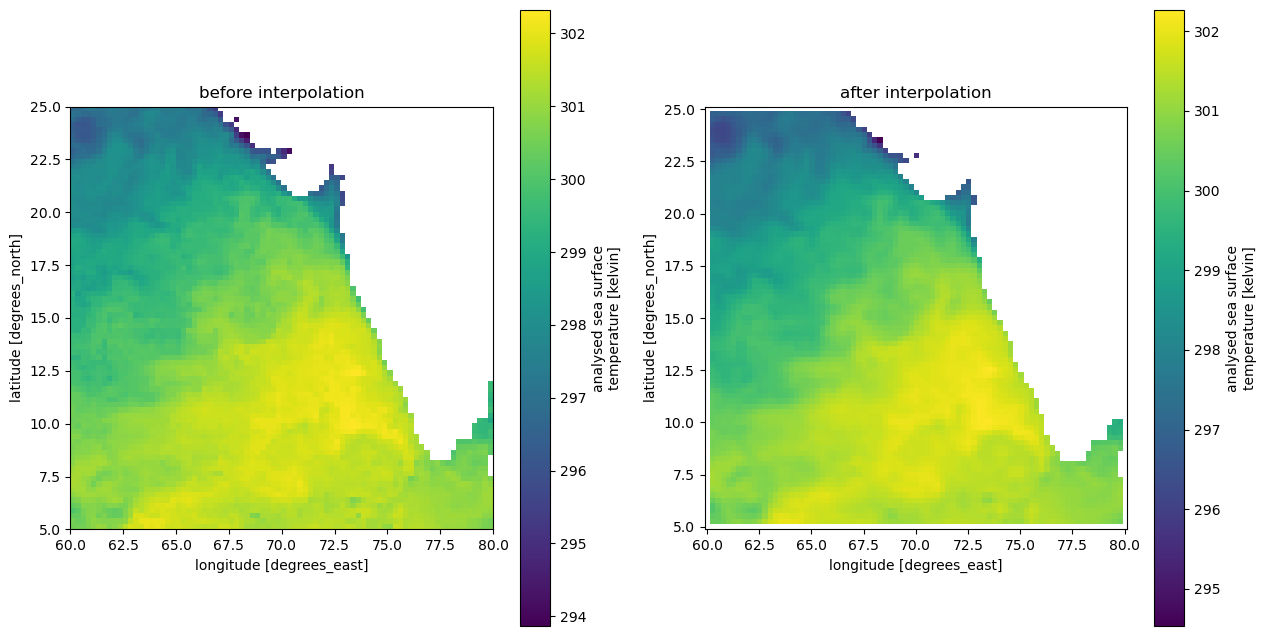

In [10]:
# verify before and after interpolation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8)) # 2 columns & 1 row, width, height 
sst.isel(time=0).plot.imshow(ax=ax1)
ax1.set_title('before interpolation')
ax1.set_aspect('equal')

sst_interp.isel(time=0).plot.imshow(ax=ax2)
ax2.set_title('after interpolation')
ax2.set_aspect('equal')

## Process Copernicus Salinity data

In [11]:
salinity # also need interpolation

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 241, time: 59)
Coordinates:
  * longitude  (longitude) float32 60.0 60.08 60.17 60.25 ... 79.83 79.92 80.0
  * latitude   (latitude) float32 5.0 5.083 5.167 5.25 ... 24.83 24.92 25.0
  * time       (time) datetime64[ns] 2003-01-01T12:00:00 ... 2003-02-28T12:00:00
Data variables:
    so         (time, latitude, longitude) float32 ...

### Interpolate

You can notice that the coordinates are not the same to era5 dataset, so let's change it

In [12]:
salinity = salinity.rename({'longitude': 'lon', 'latitude': 'lat'})

In [13]:
# fix time frame, again right-exclusive
salinity = salinity.assign_coords(time=np.arange('2003-01-01', '2003-03-01', timedelta(days=1), dtype='datetime64[ns]'))

In [14]:
salinity

<xarray.Dataset>
Dimensions:  (lon: 241, lat: 241, time: 59)
Coordinates:
  * lon      (lon) float32 60.0 60.08 60.17 60.25 ... 79.75 79.83 79.92 80.0
  * lat      (lat) float32 5.0 5.083 5.167 5.25 5.333 ... 24.75 24.83 24.92 25.0
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-02-28
Data variables:
    so       (time, lat, lon) float32 ...

In [15]:
salinity_interp = salinity.interp_like(era5)

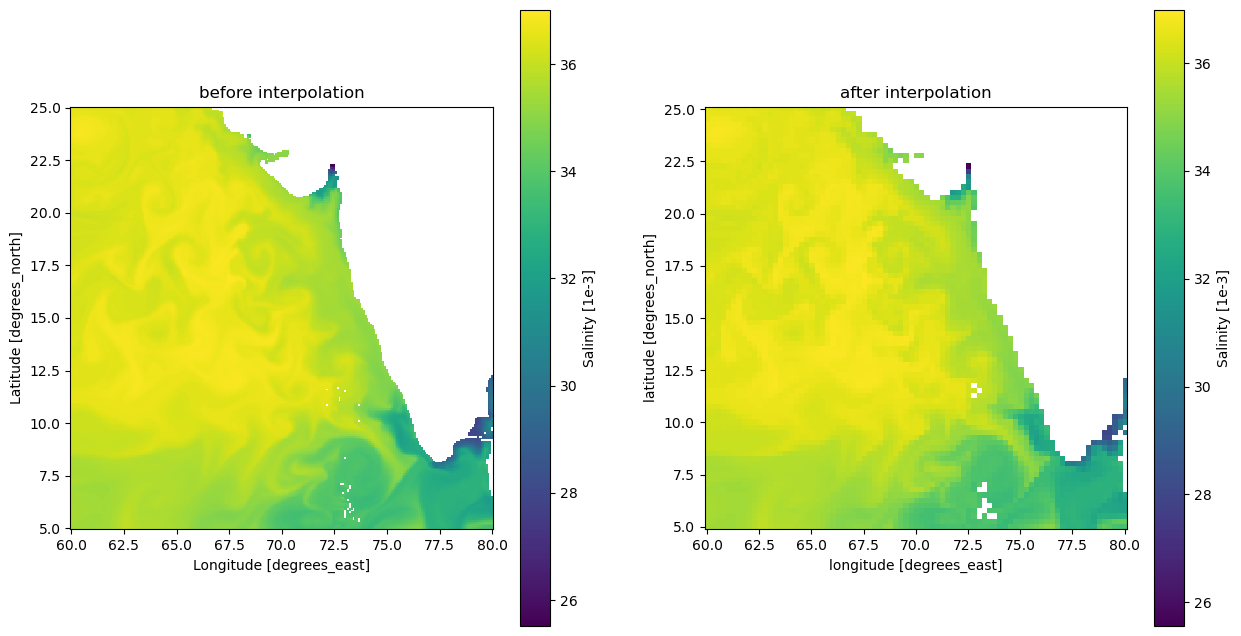

In [16]:
# verify before and after interpolation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8)) # 2 columns & 1 row, width, height 
salinity['so'].isel(time=0).plot.imshow(ax=ax1)
ax1.set_title('before interpolation')
ax1.set_aspect('equal')

salinity_interp['so'].isel(time=0).plot.imshow(ax=ax2)
ax2.set_title('after interpolation')
ax2.set_aspect('equal')

## Combine files together

Due to different attributes in each dataset coordinates, we cannot combine all datasets together by coords by simply using the combine_by_coords() function in xarray. Issue is replicated below:

In [17]:
final_ds = xr.combine_by_coords([era5, salinity_interp, sst_interp])

In [18]:
final_ds

<xarray.Dataset>
Dimensions:       (time: 59, lat: 81, lon: 81)
Coordinates:
  * time          (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-02-28
  * lat           (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 5.75 5.5 5.25 5.0
  * lon           (lon) float32 60.0 60.25 60.5 60.75 ... 79.25 79.5 79.75 80.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(59, 81, 81), meta=np.ndarray>
    u_wind        (time, lat, lon) float32 3.128 2.865 2.555 ... -3.737 -4.479
    v_wind        (time, lat, lon) float32 0.6016 0.6589 ... -1.914 -2.474
    speed         (time, lat, lon) float32 3.945 3.645 3.368 ... 4.227 5.153
    direction     (time, lat, lon) float32 22.31 17.58 13.01 ... -153.4 -151.6
    so            (time, lat, lon) float64 36.55 36.54 36.54 ... 34.0 34.08
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

## Adding metadata and rename variables

Metadata is one aspect we also need to address. Correct metadata is vital especially when we want to share our final dataset for others to use, or when we want to graph and feed data for other tools to work on. As we combine and process variables into the final dataset, some of the metadata may be lost, so we need to make sure that their metadata is reserved and resolve any conflict for the export process to proceed smoothly.

In [22]:
final_ds['speed'].attrs = {
    'units': 'm s**-1',
    'long_name': '10 metre absolute speed'
}

final_ds['direction'].attrs = {
    'units': '°C',
    'long_name': '10 metre wind direction'
}


final_ds.time.attrs = salinity.time.attrs

In [20]:
# you do not need to add everything in here, but it's an example template

final_ds.attrs = {
    'title': 'Sample of Climate Data for Coastal Upwelling Machine Learning Project in Indian Ocean',
    'summary': "Daily mean of 0.25 x 0.25 degrees gridded data from multiple climate variables that may influence the patterns of coastal upwelling in the focused area",
    'creator_name': 'Minh Phan',
    'creator_email': 'minhphan@uw.edu',
    'creator_type': 'person',
    'source': 'OSCAR, ERA5 Reanalysis, Copernicus Climate Change Service (C3S), Copernicus Marine Environment Monitoring Service (CMEMS)',
    'geospatial_lat_min': float(final_ds.lat.min().values),
    'geospatial_lat_max': float(final_ds.lat.max().values),
    'geospatial_lat_units': 'degrees_north',
    'geospatial_lat_resolution': 0.25,
    'geospatial_lon_min': float(final_ds.lon.min().values),
    'geospatial_lon_max': float(final_ds.lon.max().values),
    'geospatial_lon_units': 'degrees_east',
    'geospatial_lon_resolution': 0.25,
    'time_coverage_start': '2000-01-01T00:00:00',
    'time_coverage_end': '2002-12-31T23:59:59',
    'date_created': datetime.today().strftime('%Y-%d-%d')
}

In [23]:
final_ds

<xarray.Dataset>
Dimensions:       (time: 59, lat: 81, lon: 81)
Coordinates:
  * time          (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-02-28
  * lat           (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 5.75 5.5 5.25 5.0
  * lon           (lon) float32 60.0 60.25 60.5 60.75 ... 79.25 79.5 79.75 80.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(59, 81, 81), meta=np.ndarray>
    u_wind        (time, lat, lon) float32 3.128 2.865 2.555 ... -3.737 -4.479
    v_wind        (time, lat, lon) float32 0.6016 0.6589 ... -1.914 -2.474
    speed         (time, lat, lon) float32 3.945 3.645 3.368 ... 4.227 5.153
    direction     (time, lat, lon) float32 22.31 17.58 13.01 ... -153.4 -151.6
    so            (time, lat, lon) float64 36.55 36.54 36.54 ... 34.0 34.08
Attributes: (12/17)
    title:                      Sample of Climate Data for Coastal Upwelling ...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    creator_name:               Minh Phan
    creator_email:              minhphan@uw.edu
    creator_type:               person
    source:                     OSCAR, ERA5 Reanalysis, Copernicus Climate Ch...
    ...                         ...
    geospatial_lon_max:         80.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2002-12-31T23:59:59
    date_created:               2023-14-14

## Adding consistency across variables: convert data types, rechunking

Note that some variables has float64 dtype, while others have float32. We want to add consistency by converting all of them to float32 to save some disk space. The precision from float64 is most likely not going to be lost after the conversion, as our figures do not have enough precision to exceed the limit.

In [24]:
for var in final_ds.data_vars:
    if str(final_ds[var].dtype) == 'float64':
        final_ds[var].values = final_ds[var].astype('float32')

We also need to rechunk the dataset before we can export the data. Some of the variables have original chunk sizes, which is specified in their encodings, and we need to reset these values so that zarr would not reconvert the encoding when export is happening. This is a [known issue](https://stackoverflow.com/questions/67476513/zarr-not-respecting-chunk-size-from-xarray-and-reverting-to-original-chunk-size).


In [25]:
for var in final_ds.data_vars:
    if 'chunks' in list(final_ds[var].encoding.keys()):
        del final_ds[var].encoding['chunks']

Finally, reset chunk size for exporting to zarr:

In [26]:
array_chunk_size = {'time': 100, 'lat': final_ds.lat.shape[0], 'lon': final_ds.lon.shape[0]}
final_ds = final_ds.chunk(array_chunk_size)

## Export data

In [27]:
final_ds.to_zarr('demonstrated data/final-sample.zarr')